# Part II. Simple CNN but add the land mask as variable

**Author:** Eli Holmes (NOAA), Yifei Hang (UW Varanasi intern 2024), Jiarui Yu (UW Varanasi intern 2023)

In Part I, we fit a simple CNN but we replaced the SST and salinity land values (NaN) with 0. This causes the CNN to think SST and salinity are 0 on the land and the model has no way to "learn" the ocean/land boundary.

Let's add the mask as an input so the model can learn the land.

## Load the libraries

In [1]:
# --- Core data handling libraries ---
import xarray as xr       # for working with labeled multi-dimensional arrays
import numpy as np        # for numerical operations on arrays
import dask.array as da   # for lazy, parallel array operations (used in xarray backends)

# --- Plotting ---
import matplotlib.pyplot as plt  # for creating plots

# --- TensorFlow setup ---
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # suppress TensorFlow log spam (0=all, 3=only errors)

import tensorflow as tf  # main deep learning framework

# --- Keras (part of TensorFlow): building and training neural networks ---
from keras.models import Sequential          # lets us stack layers in a simple linear model
from keras.layers import Conv2D              # 2D convolution layer — finds spatial patterns in image-like data
from keras.layers import BatchNormalization  # stabilizes and speeds up training by normalizing activations
from keras.layers import Dropout             # randomly "drops" neurons during training to reduce overfitting
from keras.callbacks import EarlyStopping    # stops training early if validation loss doesn't improve

2025-06-10 20:08:57.948871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-10 20:08:57.966606: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-10 20:08:57.972057: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## See what machine we are on

In [2]:
# list all the physical devices
physical_devices = tf.config.list_physical_devices()
print("All Physical Devices:", physical_devices)

# list all the available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

# Print infomation for available GPU if there exists any
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print("GPU Details:", details)
else:
    print("No GPU available")

All Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Details: {'compute_capability': (7, 5), 'device_name': 'Tesla T4'}


## Load data

I created the data for Part I in `Data_Prep_Part_1`. Here I will load.

In [3]:
# read in the Zarr file; a 3D (time, lat, lon) cube for a bunch of variables in the Indian Ocean
dataset = xr.open_zarr("~/shared-readwrite/cnn/part1.zarr")

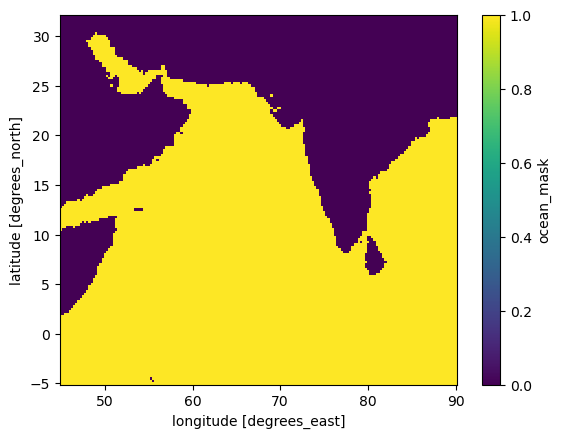

In [4]:
# the ocean mask
dataset.ocean_mask.plot();

## Process the data

We need to split into our training and testing data. I will create some functions to help with this.

**Note on Missing Values and Masking (Part 1)**

TensorFlow cannot handle any NaNs. In this first part of the tutorial, we are **not using a land or CHL mask**. Instead, we keep it simple by:

- Replacing all missing values (NaNs) with **0**
- Using the raw `CHL` data as-is, only filtering out days with too many NaNs beforehand
- Training the model to learn from the data wherever it exists. It is going to spend extra time learning "CHL" on land where CHL, SST and salinity are all set to 0.

In **Part 2**, we will show how to handle missing data more carefully using a mask during training.

In [15]:
import numpy as np
import dask.array as da

def time_series_split(data, num_var, cat_var, split_ratio=(0.7, 0.2, 0.1)):
    """
    Splits data into train, validation, and test sets.
    Replaces all NaNs with 0s for categorical, and normalizes numerical variables.

    Parameters:
        data: xarray dataset containing predictors and a "y" response
        num_var: list of numerical variable names (to normalize)
        cat_var: list of categorical variable names (no normalization)
        split_ratio: tuple of 3 floats summing to 1.0 (train, val, test)

    Returns:
        X (full input), y (full label),
        and tuple of splits: X_train, y_train, X_val, y_val, X_test, y_test
    """
    time_dim = 'time'
    if time_dim not in data.dims:
        raise ValueError("Dataset must contain a 'time' dimension.")

    pred_arrays = []

    # Process numerical variables
    for var in num_var:
        arr = data[var]
        if time_dim not in arr.dims:
            arr = arr.expand_dims({time_dim: data["time"]})
            arr = arr.broadcast_like(data["sst"])
        arr = arr.transpose(time_dim, ...)  # (time, lat, lon)
        arr_data = arr.data
        arr_data = da.nan_to_num(arr_data)
        mean = arr_data.mean()
        std = arr_data.std()
        arr_data = (arr_data - mean) / (std + 1e-8)  # avoid div by 0
        pred_arrays.append(arr_data)

    # Process categorical variables
    for var in cat_var:
        arr = data[var]
        if time_dim not in arr.dims:
            arr = arr.expand_dims({time_dim: data["time"]})
            arr = arr.broadcast_like(data["sst"])
        arr = arr.transpose(time_dim, ...)
        arr_data = da.nan_to_num(arr.data)
        pred_arrays.append(arr_data)

    # Stack predictors
    X = da.stack(pred_arrays, axis=-1)  # (time, lat, lon, n_features)

    # Process label
    y = data["y"].transpose(time_dim, ...).data
    y = da.nan_to_num(y)

    # Split by time
    total_length = X.shape[0]
    train_end = int(total_length * split_ratio[0])
    val_end = int(total_length * (split_ratio[0] + split_ratio[1]))

    X_train = X[:train_end]
    y_train = y[:train_end]
    X_val = X[train_end:val_end]
    y_val = y[train_end:val_end]
    X_test = X[val_end:]
    y_test = y[val_end:]

    return X, y, X_train, y_train, X_val, y_val, X_test, y_test

Here we create our training and test data with 2 variables using only 2020. 70% data for training, 20% for validation and 10% for testing.

In [16]:
num_var = ['sst', 'so'] 
cat_var = ['ocean_mask']
split_ratio = [.7, .2, .1]
X, y, X_train, y_train, X_val, y_val, X_test, y_test = time_series_split(dataset, num_var, cat_var, split_ratio)

## Create the CNN model

In [17]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, BatchNormalization, Dropout

def create_model_CNN(input_shape):
    """
    Create a simple 3-layer CNN model for gridded ocean data.

    Parameters
    ----------
    input_shape : tuple
        The shape of each sample, e.g., (149, 181, 2)

    Returns
    -------
    model : keras.Model
        CNN model to predict CHL from SST and salinity
    """
    model = Sequential()

    # Input layer defines the input dimensions for the CNN
    model.add(Input(shape=input_shape))

    # Layer 1 — learns fine-scale 3x3 spatial features
    # Let the model learn 64 different patterns (filters) in the data at this layer.
    # activation relu is non-linearity
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Layer 2 — expands context to 5x5; combines fine features into larger structures
    # Reduce the number of patterns (filters) so we gradually reduce model complexity
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Layer 3 — has access to ~7x7 neighborhood; outputs CHL prediction per pixel
    # Combines all the previous layer’s features into a CHL estimate at each pixel
    # 1 response (chl) — hence, 1 prediction pixel = filter
    # linear since predicting a real continuous variable (log CHL)
    model.add(Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='linear'))

    return model

### Let's build the model

We build a simple 3-layer CNN model. Each layer preserves the (lat, lon) shape and learns filters to extract spatial patterns. The model has ~20,000 trainable parameters, which we can see from `model.summary()`. This is small compared to huge modern CNNs (millions of parameters).

In [18]:
# Get shape of one input sample: (lat, lon, n_features)
input_shape = X_train.shape[1:]

# Create the model using the correct input shape
model = create_model_CNN(input_shape)

# Check the model summary
# model.summary()

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 149, 181, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 149, 181, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 149, 181, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 149, 181, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 149, 181, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 149, 181, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 149, 181, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,929 (81.75 KB)

 Trainable params: 20,737 (81.00 KB)

 Non-trainable params: 192 (768.00 B)

In [71]:
from keras import backend as K
import gc

K.clear_session()
gc.collect()

0

## Let's train the model

In [19]:
# Compile the model with Adam optimizer and mean absolute error (MAE) as both loss and evaluation metric
model.compile(
    optimizer='adam',    # Efficient and widely used optimizer
    loss='mae',          # Mean Absolute Error: good for continuous data like CHL
    metrics=['mae']      # Also track MAE during training/validation
)

# Set up early stopping to prevent overfitting
early_stop = EarlyStopping(
    patience=10,              # Stop if validation loss doesn't improve for 10 epochs
    restore_best_weights=True  # Revert to the model weights from the best epoch
)

# Create a TensorFlow dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024)  # Shuffle the data (helps generalization)
train_dataset = train_dataset.batch(8)                   # Batch size = 8

# Create a TensorFlow dataset for validation (no shuffle)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(8)

# Train the model
history = model.fit(
    train_dataset,
    epochs=50,                    # Maximum number of training epochs
    validation_data=val_dataset, # Use validation data during training
    callbacks=[early_stop]       # Stop early if no improvement
)


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 1.4042 - mae: 1.4042 - val_loss: 1.0132 - val_mae: 1.0132
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.9795 - mae: 0.9795 - val_loss: 1.2703 - val_mae: 1.2703
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7209 - mae: 0.7209 - val_loss: 1.2963 - val_mae: 1.2963
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.5796 - mae: 0.5796 - val_loss: 1.2904 - val_mae: 1.2904
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5098 - mae: 0.5098 - val_loss: 1.2454 - val_mae: 1.2454
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.4459 - mae: 0.4459 - val_loss: 1.1325 - val_mae: 1.1325
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4048 - mae: 0.4048 - val_loss: 1.0939 - val_mae: 1.0939
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3781 - mae: 0.3781 - val_loss: 0.9163 - val_mae: 0.9163
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.364

## Plot training & validation loss values

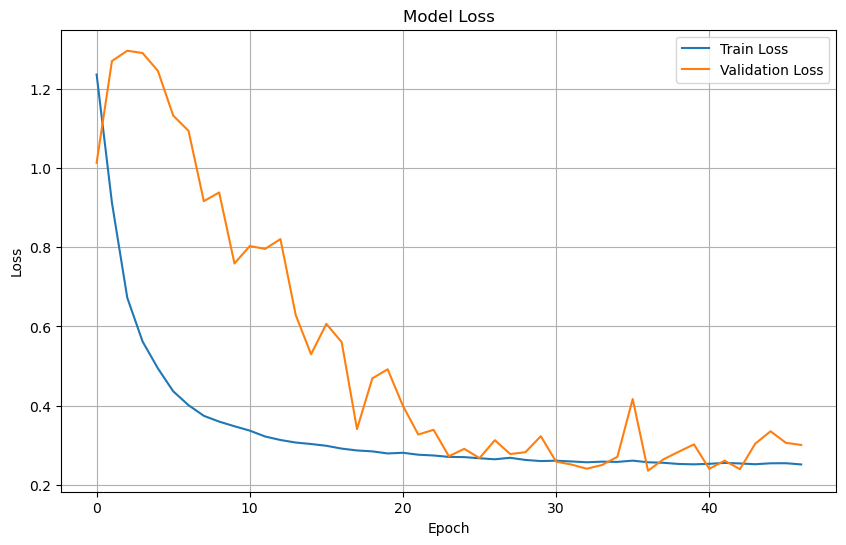

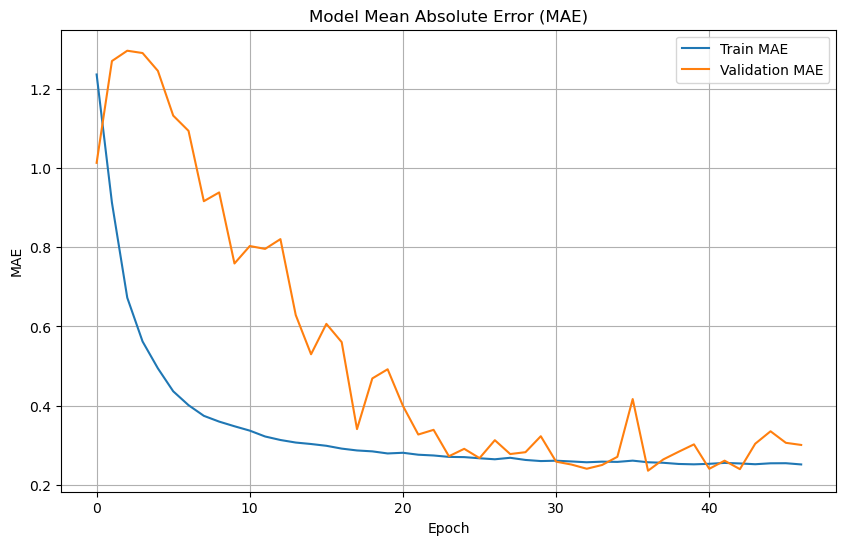

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Plot training & validation MAE values
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

## Prepare test dataset

In [27]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(4)

# Evaluate the model on the test dataset
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 1.2188 - masked_mae: 1.2040
Test Loss: 1.1626996994018555
Test MAE: 1.0888657569885254


## Make some maps of our predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


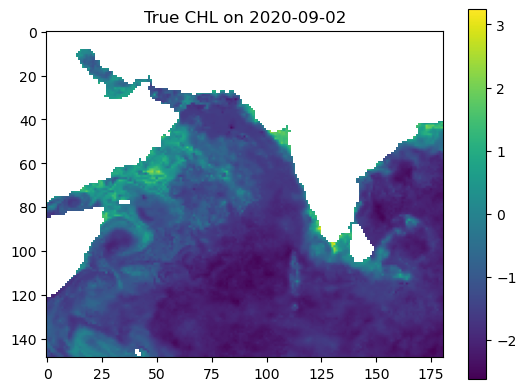

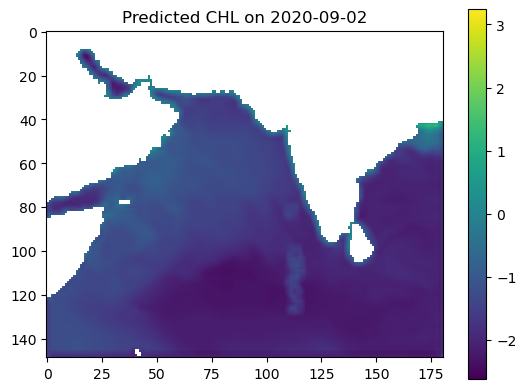

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Example: date to predict
date_to_predict = np.datetime64("2020-09-02")

# Get index of that date
available_times = dataset["time"].values
date_index = np.where(available_times == date_to_predict)[0][0]

# Prepare input (X: shape = [time, lat, lon, n_features])
input_data = X[date_index]  # shape = (lat, lon, n_features)
input_data = np.array(input_data)     # convert to numpy

# Predict
predicted_output = model.predict(input_data[np.newaxis, ...])[0]
predicted_output = predicted_output[:, :, 0]  # shape = (lat, lon)

# True value from y
true_output = y[date_index]

# Mask land (land_mask = ~ocean)
land_mask = ~dataset["ocean_mask"].values
predicted_output[land_mask] = np.nan
true_output = np.where(land_mask, np.nan, true_output)

# Plot
vmin = np.nanmin([true_output, predicted_output])
vmax = np.nanmax([true_output, predicted_output])

plt.imshow(true_output, vmin=vmin, vmax=vmax, cmap='viridis')
plt.colorbar()
plt.title(f"True CHL on {date_to_predict}")
plt.show()

plt.imshow(predicted_output, vmin=vmin, vmax=vmax, cmap='viridis')
plt.colorbar()
plt.title(f"Predicted CHL on {date_to_predict}")
plt.show()


### Let's look at all the months

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


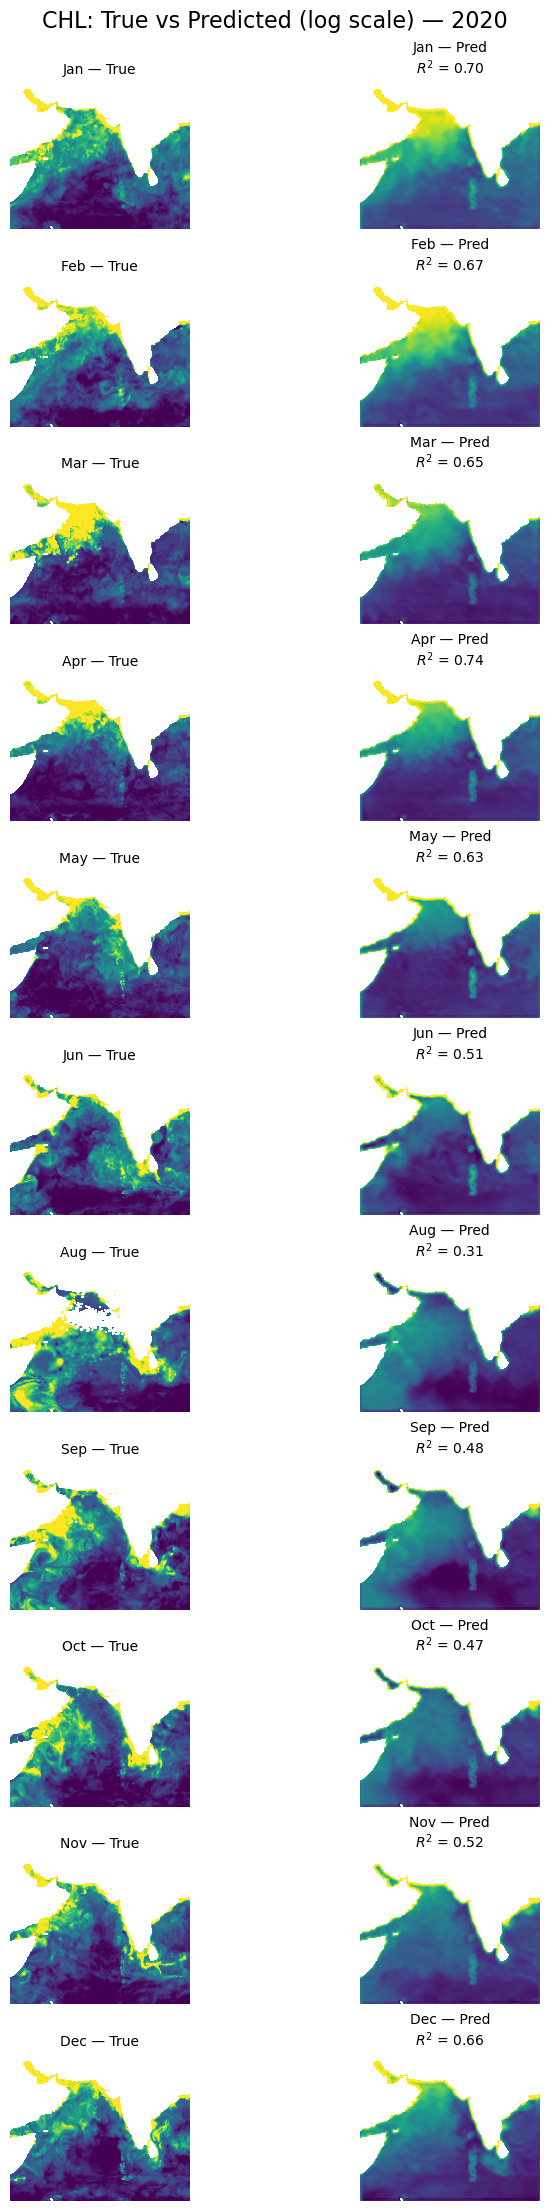

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

# Get available time points and group by month
available_dates = pd.to_datetime(dataset.time.values)
monthly_dates = (
    pd.Series(available_dates)
    .groupby([available_dates.year, available_dates.month])
    .min()
    .sort_values()
)
n_months = len(monthly_dates)

# lat/lon info
lat = dataset.lat.values
lon = dataset.lon.values
extent = [lon.min(), lon.max(), lat.min(), lat.max()]
flip_lat = lat[0] > lat[-1]
land_mask = ~dataset["ocean_mask"].values

# Create figure and axes
fig, axs = plt.subplots(n_months, 2, figsize=(7, 2 * n_months), constrained_layout=True)

for i, date in enumerate(monthly_dates):
    # Get time index
    date_index = np.where(available_dates == date)[0][0]

    # True output
    true_output = dataset['y'].sel(time=date).values
    if flip_lat:
        true_output = np.flipud(true_output)

    # Prediction
    input_data = np.array(X[date_index])
    predicted_output = model.predict(input_data[np.newaxis, ...])[0]
    predicted_output = predicted_output[:, :, 0]  # shape = (lat, lon)
    
    # Mask land (land_mask = ~ocean)
    predicted_output[land_mask] = np.nan

    if flip_lat:
        predicted_output = np.flipud(predicted_output)

    # Shared color scale
    vmin = np.nanpercentile([true_output, predicted_output], 5)
    vmax = np.nanpercentile([true_output, predicted_output], 95)

    # Compute R² (flatten and mask NaNs)
    true_flat = true_output.flatten()
    pred_flat = predicted_output.flatten()
    valid_mask = ~np.isnan(true_flat) & ~np.isnan(pred_flat)
    r2 = r2_score(true_flat[valid_mask], pred_flat[valid_mask])

    # Plot true
    axs[i, 0].imshow(true_output, origin='lower', extent=extent,
                     vmin=vmin, vmax=vmax, cmap='viridis',
                     aspect='equal')
    axs[i, 0].set_title(f"{date.strftime('%b')} — True", fontsize=10)
    axs[i, 0].axis('off')

    # Plot predicted with R²
    axs[i, 1].imshow(predicted_output, origin='lower', extent=extent,
                     vmin=vmin, vmax=vmax, cmap='viridis', 
                     aspect='equal')
    axs[i, 1].set_title(f"{date.strftime('%b')} — Pred\n$R^2$ = {r2:.2f}", fontsize=10)
    axs[i, 1].axis('off')

plt.suptitle('CHL: True vs Predicted (log scale) — 2020', fontsize=16)
plt.show()


### Glow around land

It is a little hard to see but there is a "glow" on the land/ocean boundary. This is because we set land to 0 and the model is training on the land and using that land "0" to help make predictions at the land/ocean boundary.

## Summary

This is a simple CNNs model but it managed to do ok with just 2 variables. But we **have** to deal with the land mask. We will do that in Part 2. In Part 3, we will start doing a more realistic problem: gap-filling cloud-masked level 3 data. Then we will start getting more reasonable predictions and without all the 'smudging'.